# Modelos de regresión lineal

![BLR](https://upload.wikimedia.org/wikipedia/commons/e/ed/Bayes_icon.svg)

Hasta ahora hemos visto modelos de regresión lineal, usando inferencia exacta para la estimación de la distribución posterior de los parámetros, bajo un caso particular (suponiendo la varianza de la dispersión conocida). Si quisiéramos asumir previas distintas a la normal para los parámetros, incluyendo una previa para el parámetro de varianza, entonces la inferencia exacta de la distribución posterior se vuelve prácticamente imposible.

En este tema, estudiamos el uso de muestreo de la distribución posterior usando técnicas Montecarlo, dándonos la libertad de elegir la previa que mejor represente nuestro conocimiento de la situación.

> **Objetivos:**
> - Revisitar modelos de predicción lineal desde una perspectiva de Montecarlo.

> **Referencias:**
> 
> - Statistical Rethinking: A Bayesian Course with Examples in R and Stan (2nd edition) - Richard McElreath.

## 1. Predicción lineal

Lo que acabamos de ver es un modelo Gaussiano para la altura de una población de adultos. Sin embargo, este modelo no tiene el componente de *regresión*.

Es común que queramos modelar como el resultado de cierta variable se relaciona con otra(s) variable(s), llamada(s) **predictor(es)**. Si el predictor tiene alguna asociación estadística con la variable de interés, la podemos usar para *predecir* dicha variable.

En este caso estudiaremos como incluir estos predictores de forma lineal en el modelo. 

Seguiremos usando los datos de los adultos en la población, pero esta vez, veremos como la altura se relaciona con el peso:

In [1]:
# Importar pandas y pyplot
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Leer datos (separados por ;)
height_data = pd.read_csv("data/Howell1.csv", sep=";")
height_data.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [3]:
# Extraer datos de adultos
adult_height_data = height_data[height_data['age'] >= 18].copy()

In [4]:
# Algunas filas
adult_height_data.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [5]:
# Separar en train y test - para después
train = adult_height_data.sample(frac=0.8, random_state=1)
test = adult_height_data.drop(train.index)

Text(0, 0.5, 'Estatura (cm)')

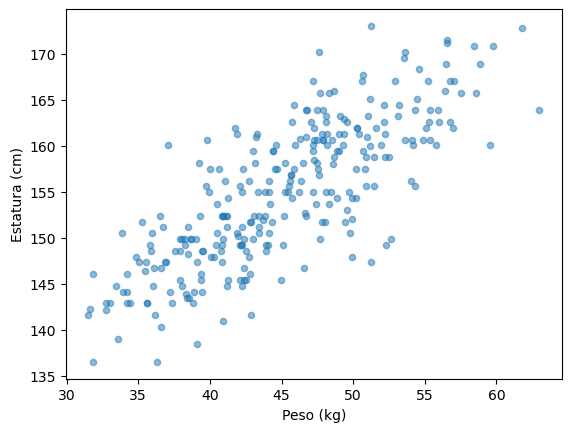

In [8]:
# Scatter plot - train
train.plot.scatter(x='weight', y='height', alpha=0.5)
plt.xlabel("Peso (kg)")
plt.ylabel("Estatura (cm)")

Del gráfico anterior, observamos que en definitiva hay una relación marcada entre la altura y el peso. Es decir, conocer el peso de una persona nos ayuda a predecir su altura.

**¿Cómo adecuamos el modelo de la altura para incluir el peso como predictor?**

La estrategia es modificar el parámetro $\mu$ de la distribución Gaussiana, para que sea una función lineal del predictor. Ahora, para los parámetros de esta función, tendremos que declarar distribuciones previas.

De forma que, teníamos:

$$
\begin{align}
\begin{array}{lcl}
h_i & \sim & \text{Normal}(\mu, \sigma) \\
\mu & \sim & \text{Normal}(170, 20) \\
\sigma & \sim & \text{Uniform}(0, 50)
\end{array}
\end{align}
$$

Ahora, sea $w_i$ el peso de la persona $i$ y sean $\bar{w}$ el promedio de todos los pesos. De esta forma:

$$
\begin{align}
\begin{array}{lcl}
h_i & \sim & \text{Normal}(\mu_i, \sigma) \\
\mu_i & = & \alpha + \beta(w_i - \bar{w}) \\
\alpha & \sim & \text{Normal}(170, 20) \\
\beta & \sim & \text{Normal}(0, 10) \\
\sigma & \sim & \text{Uniform}(0, 50)
\end{array}
\end{align}
$$

*¿Qué significa esto?*

- Como antes, la primera expresión es la verosimilitud (probabilidad de los datos). Es casi la misma expresión, nada más notemos que cambiamos la media general $\mu$, por una media $\mu_i$ para cada observación. Es decir, la media depende de los valores específicos de cada observación.

- La segunda expresión, corresponde al modelo lineal. $\mu$ ya no es un parámetro que estimemos, sino una relación determinista (notar el símbolo $=$ en lugar de $\sim$) a los nuevos parámetros $\alpha$ y $\beta$, y que depende de la variable observada $w_i$.

  ¿Porqué incluir como predictor $w_i - \bar{w}$ en lugar de símplemente $w_i$? Algo importante cuando modelamos es poder entender los parámetros que estamos introduciendo. Notemos que de la manera en que especificamos el modelo $\mu=\alpha$ cuando $w_i=\bar{w}$; es decir, $\alpha$ es el valor esperado de la altura cuando el peso es promedio.

  ¿Y qué pasa con $\beta$? Bueno, pues el parámetro $\beta$ es el cambio esperado en la altura, cuando el peso cambia $1$ unidad (kg).

- Las demás expresiones, como antes, son las previas de nuestros parámetros, que deberemos ajustar con una debida simulación predictiva previa de ser necesario.

In [9]:
# Importart scipy.stats
from scipy import stats
# Importar numpy
import numpy as np

In [10]:
# Previas
alpha = stats.norm(loc=170, scale=20)
beta = stats.norm(loc=0, scale=10)
sigma = stats.uniform(loc=0, scale=50)

Text(0, 0.5, 'Estatura (cm)')

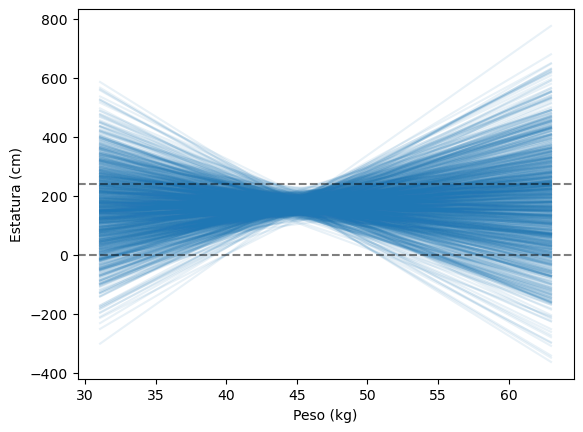

In [13]:
# Simulación previa predictiva
# Número de muestras
N = 1000
# Vector de pesos (w)
w = adult_height_data['weight'].values
# Peso promedio (w_bar)
w_bar = np.mean(w)
# Muestras de alpha, beta y mu
alpha_samples = alpha.rvs(size=N)
beta_samples = beta.rvs(size=N)
mu = alpha_samples[:, None] + beta_samples[:, None] * (w - w_bar)
# Gráfico de muestras de mu vs peso
idx_plot = np.argsort(w)
plt.plot(w[idx_plot], mu[:, idx_plot].T, color='C0', alpha=0.1)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
plt.axhline(y=240, color='k', linestyle='--', alpha=0.5)
plt.xlabel("Peso (kg)")
plt.ylabel("Estatura (cm)")

Observamos que usando estas previas, las la altura promedio puede llegar a tomar valores bastante extremos para valores normales del peso. Podemos hacer algo mejor.

De la gráfica de puntos, observamos que la relación entre la altura y el peso es positiva. Una manera común de restringir un parámetro a que sea positivo es usando la distribución $\text{Log-Normal}$. Si definimos $\beta$ como $\text{Log-Normal}(0, 1)$, significa que el logaritmo de $\beta$ tiene una distribución $\text{Normal}(0, 1)$:

$$
\beta \sim \text{Log-Normal}(0, 1)
$$

In [15]:
# Densidad lognormal
beta = stats.lognorm(s=1)

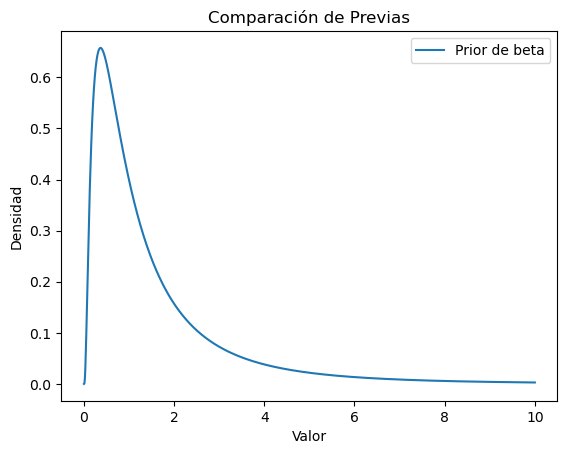

In [17]:
# Gráfico de comparación de previas para beta
x = np.linspace(0, 10, 1000)
plt.plot(x, beta.pdf(x), color='C0', label='Prior de beta')
plt.xlabel("Valor")
plt.ylabel("Densidad")
plt.title("Comparación de Previas")
plt.legend()

Text(0, 0.5, 'Estatura (cm)')

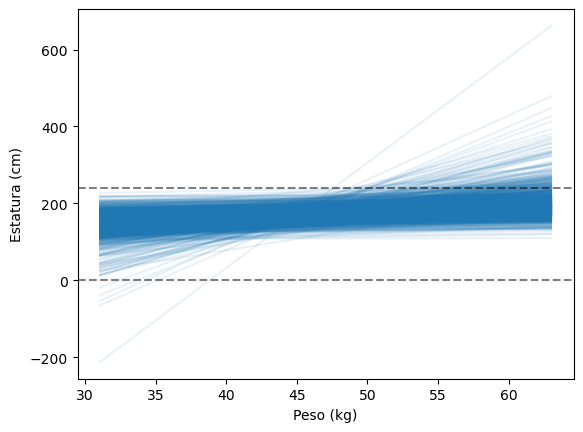

In [18]:
# Número de muestras
N = 1000
# Vector de pesos (w)
w = adult_height_data['weight'].values
# Peso promedio (w_bar)
w_bar = np.mean(w)
# Muestras de alpha, beta y mu
alpha_samples = alpha.rvs(size=N)
beta_samples = beta.rvs(size=N)
mu = alpha_samples[:, None] + beta_samples[:, None] * (w - w_bar)
# Gráfico de muestras de mu vs peso
idx_plot = np.argsort(w)
plt.plot(w[idx_plot], mu[:, idx_plot].T, color='C0', alpha=0.1)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
plt.axhline(y=240, color='k', linestyle='--', alpha=0.5)
plt.xlabel("Peso (kg)")
plt.ylabel("Estatura (cm)")

¡Esto se ve mucho mejor!

De forma que nuestro modelo completo es:

$$
\begin{align}
\begin{array}{lcl}
h_i & \sim & \text{Normal}(\mu_i, \sigma) \\
\mu_i & = & \alpha + \beta(w_i - \bar{w}) \\
\alpha & \sim & \text{Normal}(170, 20) \\
\beta & \sim & \text{Log-Normal}(0, 1) \\
\sigma & \sim & \text{Uniform}(0, 50)
\end{array}
\end{align}
$$

**Estimemos la distribución posterior usando MCMC:**

In [19]:
# Importar pymc
import pymc as pm
# Importar arviz
import arviz as az

In [20]:
# Peso
w = train['weight'].values
# Peso promedio
w_bar = np.mean(w)
# Modelo
with pm.Model() as linear_model:
    # Priors
    alpha = pm.Normal('alpha', mu=170, sigma=20)
    beta = pm.LogNormal('beta', sigma=1)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    # Mu
    mu = pm.Deterministic('mu', alpha + beta * (w - w_bar))
    # Likelihood
    height_obs = pm.Normal('height_obs', mu=mu, sigma=sigma, observed=train['height'].values)
    # Sampleo
    trace = pm.sample(2000, tune=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 22 seconds.


In [21]:
# Distribución posterior de los parámetros
trace.posterior

<xarray.Dataset> Size: 18MB
Dimensions:   (chain: 4, draw: 2000, mu_dim_0: 282)
Coordinates:
  * chain     (chain) int32 16B 0 1 2 3
  * draw      (draw) int32 8kB 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999
  * mu_dim_0  (mu_dim_0) int32 1kB 0 1 2 3 4 5 6 ... 275 276 277 278 279 280 281
Data variables:
    alpha     (chain, draw) float64 64kB 154.7 155.2 155.2 ... 154.8 154.8 154.9
    beta      (chain, draw) float64 64kB 0.9118 0.9436 0.9436 ... 0.9316 0.9275
    sigma     (chain, draw) float64 64kB 5.043 4.631 4.631 ... 5.014 5.014 4.539
    mu        (chain, draw, mu_dim_0) float64 18MB 160.5 152.0 ... 145.6 150.9
Attributes:
    created_at:                 2025-10-29T02:51:48.208552
    arviz_version:              0.13.0
    inference_library:          pymc
    inference_library_version:  4.3.0
    sampling_time:              21.82749080657959
    tuning_steps:               1000

array([<Axes: title={'center': 'alpha'}>,
       <Axes: title={'center': 'beta'}>,
       <Axes: title={'center': 'sigma'}>], dtype=object)

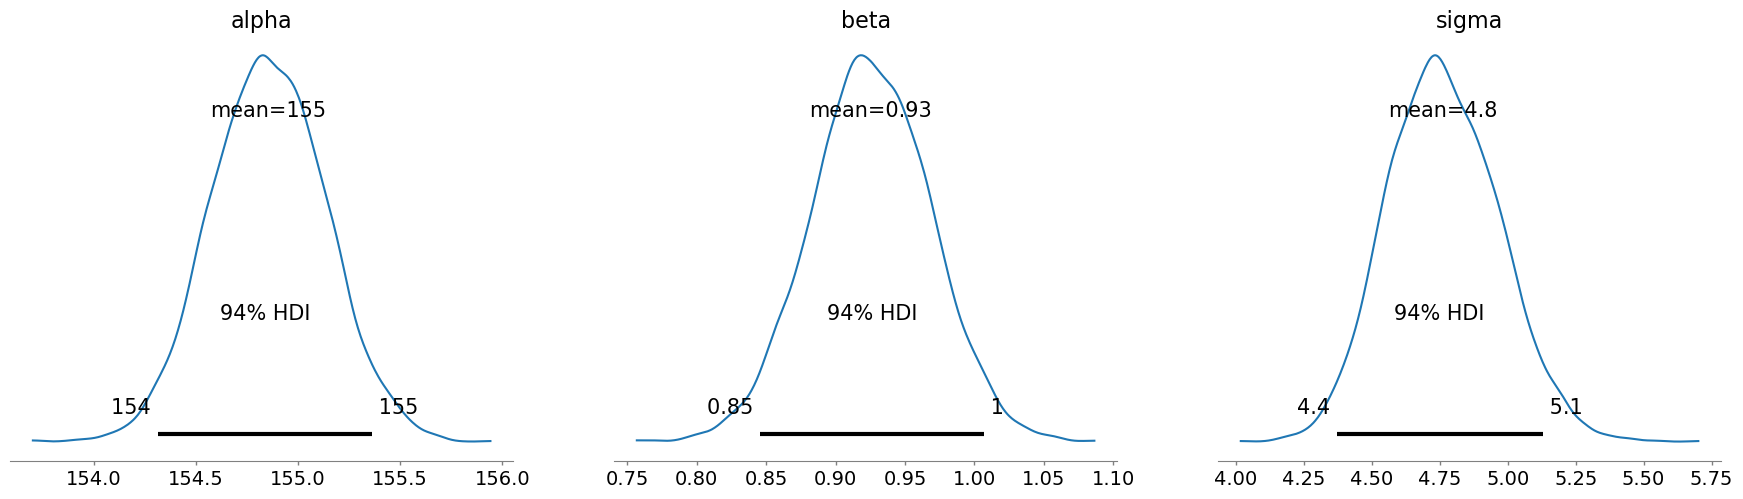

In [22]:
# az.plot_posterior
az.plot_posterior(trace, var_names=['alpha', 'beta', 'sigma'])

¿Qué podemos decir?

- La altura promedio, al peso promedio está alrededor de 155 cm.

- Por cada 1 kg adicional, se espera que la altura sea ~0.90 cm mayor.

- El 94% de la probabilidad de la distribución posterior de $\beta$ yace entre 0.82 y 0.98, lo que indica que valores cercanos a cero y valores mayores a uno, no son compatibles con los datos y el modelo.

**Predicciones con la posterior**

La idea principal de este modelo es hacer predicciones con él. Veamos como hacerlo.

Lo primero que podríamos hacer es tomar el promedio de las muestras de $\alpha$ y $\beta$, y graficar la relación promedio:

In [30]:
# Objeto de muestreo
ab_df = trace.posterior[["alpha", "beta"]].to_dataframe()
ab_df.head()

alpha      beta
chain draw                      
0     0     154.724179  0.911827
      1     155.214964  0.943597
      2     155.214964  0.943597
      3     155.534211  0.993645
      4     154.324926  0.984467

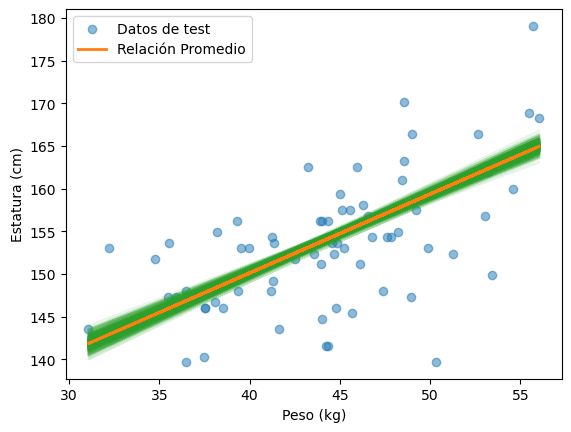

In [32]:
# Relación promedio
mu = ab_df['alpha'].mean() + ab_df['beta'].mean() * (test['weight'].values - w_bar)
# Gráfico de relación promedio vs datos de test
plt.scatter(test['weight'], test['height'], alpha=0.5, label='Datos de test')
for i in np.random.randint(0, len(ab_df), size=500):
    mu_sample = ab_df['alpha'].iloc[i] + ab_df['beta'].iloc[i] * (test['weight'].values - w_bar)
    plt.plot(test['weight'], mu_sample, color='C2', alpha=0.1)
plt.plot(test['weight'], mu, color='C1', label='Relación Promedio', linewidth=2)
plt.xlabel("Peso (kg)")
plt.ylabel("Estatura (cm)")
plt.legend()

Una pregunta que nos podríamos hacer es, ¿Cuánto es la altura promedio de una persona de 60kg?. Una vez más, podemos usar las muestras de la posterior para responder a esta pregunta:

In [34]:
# mu at 60
mu_at_60 = ab_df['alpha'] + ab_df['beta'] * (60 - w_bar)
mu_at_60

chain  draw
0      0       168.292350
       1       169.255878
       2       169.255878
       3       170.319842
       4       168.974000
                  ...    
3      1995    168.920631
       1996    168.625554
       1997    168.707784
       1998    168.707784
       1999    168.680673
Length: 8000, dtype: float64

<Axes: >

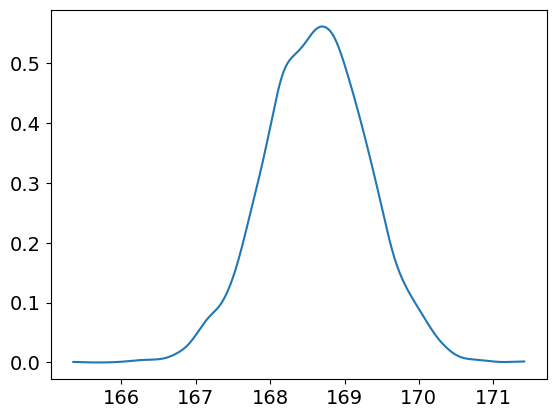

In [38]:
# kde plot
az.plot_kde(mu_at_60.values)

In [40]:
# az.hdi
az.hdi(mu_at_60.values, hdi_prob=0.89)

array([167.54097135, 169.75517871])

La altura promedio (89%) está entre 167 cm y 169 cm (condicional al modelo y los datos), dado que el peso es 60 kg.

**¿Y $\sigma$?**

Recordemos que el modelo de la altura era:

$$
h_i \sim \text{Normal}(\mu_i, \sigma)
$$

y aunque hasta ahora solo hemos hablado de $\mu$, la variación fuera del promedio es bastante importante.

Primero, generamos las muestras de predicción. Como antes, podríamos hacerlo a mano, pero pymc lo puede hacer por nosotros:

In [48]:
# Peso
w = train['weight'].values
# Peso promedio
w_bar = w.mean()
# Modelo
with pm.Model() as linear_model:
    w = pm.MutableData('w', w, dims='obs_dim')
    # Priors
    alpha = pm.Normal('alpha', mu=170, sigma=20)
    beta = pm.LogNormal('beta', sigma=1)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    # Mu
    mu = pm.Deterministic('mu', alpha + beta * (w - w_bar), dims='obs_dim')
    # Likelihood
    height_obs = pm.Normal('height_obs', mu=mu, sigma=sigma, observed=train['height'].values, dims='obs_dim')
    # Sampleo
    trace = pm.sample(2000, tune=1000, return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 21 seconds.


In [49]:
# Con el modelo entrenado predecimos sobre datos nuevos
w = test["weight"].values
# Generamos muestras predictivas de la posterior
with linear_model:
    # Actualizamos valores de w
    pm.set_data(
        {"w": w},
        coords={"obs_dim": np.arange(len(w)) + 1000}
    )
    height_post_pred = pm.sample_posterior_predictive(
        trace,
        var_names=["mu", "height_obs"],
        return_inferencedata=True,
        predictions=True,
        extend_inferencedata=True
    )

Sampling: [height_obs]


c:\Users\esjim\anaconda3\envs\meb2025_v4\lib\site-packages\pymc\backends\arviz.py:659: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  converter.nchains = idata_orig["posterior"].dims["chain"]
c:\Users\esjim\anaconda3\envs\meb2025_v4\lib\site-packages\pymc\backends\arviz.py:660: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  converter.ndraws = idata_orig["posterior"].dims["draw"]


In [50]:
height_post_pred

Inference data with groups:
	> posterior
	> predictions
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data
	> predictions_constant_data

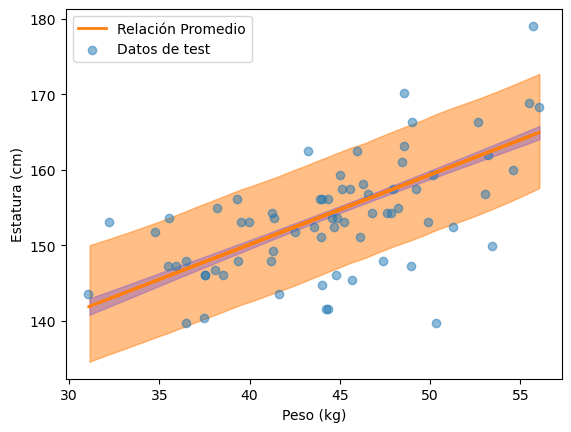

In [54]:
# Intervalo de credibilidad de la altura
az.plot_hdi(
    test['weight'],
    height_post_pred.predictions["height_obs"],
    hdi_prob=0.89
)
# Intervalo de credibilidad de la altura promedio
az.plot_hdi(
    test['weight'],
    height_post_pred.predictions["mu"],
    hdi_prob=0.89,
    color='C4',
)
# Línea promedio
plt.plot(
    test['weight'],
    height_post_pred.predictions["mu"].mean(dim=("chain", "draw")),
    color='C1',
    label='Relación Promedio',
    linewidth=2
)
# Nube de puntos
plt.scatter(test['weight'], test['height'], alpha=0.5, label='Datos de test')
# Etiquetas
plt.xlabel("Peso (kg)")
plt.ylabel("Estatura (cm)")
plt.legend()

### Evaluación

In [55]:
from sklearn.metrics import mean_squared_error, r2_score

In [57]:
r2_score(test["height"], height_post_pred.predictions["mu"].mean(("chain", "draw")))

0.32113668666725836

In [58]:
mean_squared_error(test["height"], height_post_pred.predictions["mu"].mean(("chain", "draw")))

39.73256756920272

In [61]:
lower, higher = np.array(az.hdi(height_post_pred.predictions["height_obs"], hdi_prob=0.94)["height_obs"]).T
lower, higher

(array([137.62622362, 153.30568954, 155.6290697 , 149.42544142,
        136.99876285, 139.09629876, 139.97283212, 147.90184456,
        142.4987843 , 145.02804009, 147.98741514, 146.42016475,
        140.55392297, 146.83673103, 155.57159602, 148.93092199,
        151.21235733, 147.18820812, 138.64454225, 145.19829755,
        148.85978375, 148.43887786, 153.37702722, 144.98424389,
        133.62955845, 138.04318813, 150.55578295, 149.29030901,
        146.86787317, 141.82660598, 146.22789189, 145.52044067,
        132.98115288, 147.27747578, 149.14863967, 143.73171289,
        141.67766543, 145.91050742, 145.13261001, 137.36314531,
        144.72903761, 150.25761534, 149.41174337, 141.13683904,
        154.7566418 , 141.87842358, 143.36526622, 144.67897234,
        153.41931558, 145.48080062, 147.15809645, 144.69170856,
        155.77333667, 145.6835088 , 140.58350921, 136.63971437,
        140.20452346, 138.57775398, 144.48004188, 148.389625  ,
        149.29594865, 146.74455317, 150.

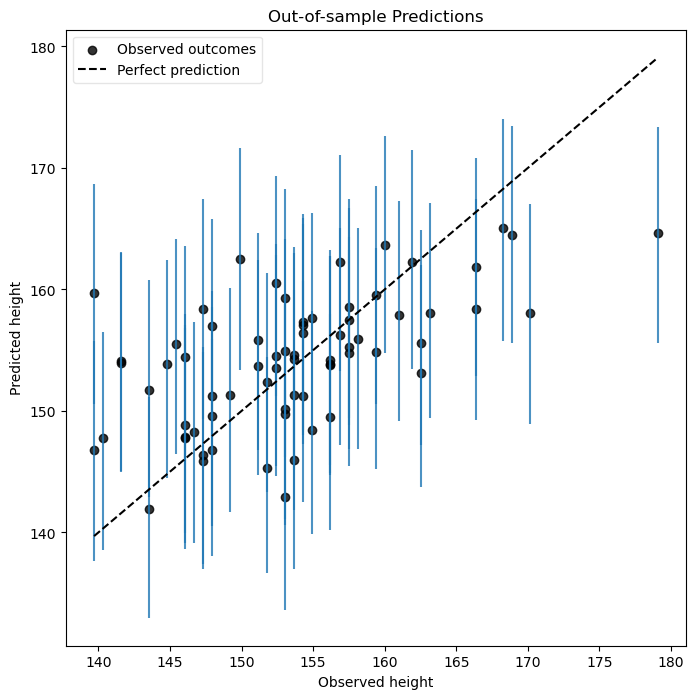

In [63]:
_, ax = plt.subplots(figsize=(8, 8))

model_preds = height_post_pred.predictions

# uncertainty about the estimates:
ax.vlines(
    test["height"].values,
    *az.hdi(model_preds)["height_obs"].transpose("hdi", ...),
    alpha=0.8,
)

# actual outcomes:
ax.scatter(
    x=test["height"].values,
    y=model_preds["height_obs"].mean(("chain", "draw")),
    marker="o",
    color="k",
    alpha=0.8,
    label="Observed outcomes",
)

x_min = test["height"].min()
x_max = test["height"].max()
ax.plot([x_min, x_max], [x_min, x_max], linestyle="--", color="k", label="Perfect prediction")
ax.set_xlabel("Observed height")
ax.set_ylabel("Predicted height")
ax.set_title("Out-of-sample Predictions")
ax.legend(fontsize=10, frameon=True, framealpha=0.5);

In [66]:
((lower < test["height"].values) & (test["height"].values < higher)).mean()

0.8571428571428571

## 2. Comentarios finales

Como en el módulo 1, podemos usar este mismo tipo de modelos lineales en los parámetros para representar relaciones no lineales entre los datos. Podemos usar polinomios, o cualquier otro tipo de representaciones no lineales que nos interese.

Por ejemplo, si consideraramos todos los datos, incluyendo los de los niños:

Text(0, 0.5, 'Height (cm)')

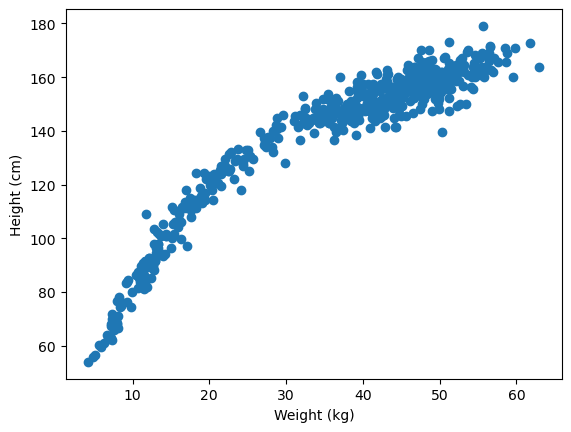

In [68]:
# Scatter plot
plt.scatter(height_data["weight"], height_data["height"])
plt.xlabel("Weight (kg)")
plt.ylabel("Height (cm)")

Observamos una relación cúbica. **Tarea**

**Ayuda**. Estandarizar el peso antes.

# Anuncios

## 1. Quiz tema 8 el jueves 30 de oct.

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Esteban Jiménez Rodríguez.
</footer>